In [ ]:
!nvidia-smi

### Get  the data 

In [ ]:
# download 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

In [3]:
# unzip
import zipfile 
def unzip(zip_path):
  zipref = zipfile.ZipFile(zip_path, "r")
  zipref.extractall()
  zipref.close()
unzip("101_food_classes_10_percent.zip")

### Preprocessing

In [4]:
import tensorflow as tf

1.   **shuffle=False for the test data**
2.   **label mode='categorical' bcz we need the probabilities (confidence)**
3.   **rescaling depends on the architecture we are using**

In [7]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"
IMAGE_SIZE = (224, 224)

In [ ]:
# preprocssing (scaling or not depends on the archiytecture we are using, efficientNet has it's built in rescaling layer)
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    shuffle=False # very important 
)

In [11]:
class_names = train_data.class_names
len(class_names)

101

### Build our model

**Creating the augmentation layer**

In [13]:
# data augmentaion layer => benifit happens with gpu 
# what is the benifit of data augmentation ?
data_augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomWidth(0.2)
], name="data_augmenhtaion_layer")

**Checkpoints callback**

In [15]:
checkpoint_path = "checkpoint/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

**Features extraction**

In [ ]:
!nvidia-smi

In [18]:
# base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False) 
# ------------ freezing the layers 
base_model.trainable = False
# inputs 
inputs = tf.keras.layers.Input(shape=IMAGE_SIZE + (3,), name="input_layer")
#----
x = data_augmentation_layer(inputs)
x = base_model(x)
# pooling (features vector)
# why 2D ?? and why this layer not another one (maxpoolinglayer)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
# outputs 
outputs = tf.keras.layers.Dense(units=len(class_names), activation='softmax')(x)
# model 
model = tf.keras.Model(inputs, outputs)
# compiling 
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=["accuracy"])

**Summary**

In [19]:
# summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmenhtaion_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [21]:
[layer.trainable for layer in model.layers]

[True, True, False, True, True]

In [22]:
base_model.trainable_variables

[]

**Fitting (validation data only 15% to save some time)**

In [23]:
# history 
history = model.fit(
      train_data, 
      epochs=5, 
      callbacks=[checkpoint_callback],
      validation_data=test_data,
      steps_per_epoch=len(train_data),
      validation_steps=int(0.15*len(test_data)) # to accelerate 
    )

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.5112 - accuracy: 0.2409
Epoch 1: saving model to checkpoint/checkpoint.ckpt
237/237 [==============================] - 54s 153ms/step - loss: 3.5112 - accuracy: 0.2409 - val_loss: 2.6583 - val_accuracy: 0.4115
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.4176 - accuracy: 0.4430
Epoch 2: saving model to checkpoint/checkpoint.ckpt
237/237 [==============================] - 27s 111ms/step - loss: 2.4176 - accuracy: 0.4430 - val_loss: 2.1914 - val_accuracy: 0.4791
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 2.0471 - accuracy: 0.5139
Epoch 3: saving model to checkpoint/checkpoint.ckpt
237/237 [==============================] - 27s 110ms/step - loss: 2.0471 - accuracy: 0.5139 - val_loss: 2.0253 - val_accuracy: 0.4992
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 1.8361 - accuracy: 0.5583
Epoch 4: saving model to checkpoint/checkpoint.ckpt
237/237 [=

In [24]:
# evaluating on the whole test_data 
evaluation_result = model.evaluate(test_data)
evaluation_result

790/790 [==============================] - 57s 72ms/step - loss: 1.6961 - accuracy: 0.5573


[1.6961007118225098, 0.5573069453239441]

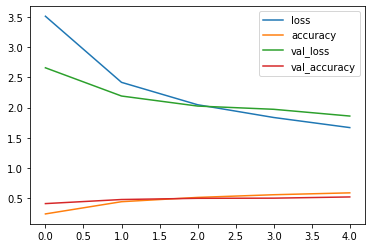

In [27]:
# visualizing the history 
import pandas as pd 
pd.DataFrame(history.history).plot();

**Fine tunning**

In [28]:
# load our model weights (checkpoints)
base_model.trainable = True 
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [29]:
# recompile bcz we had changed in our model 
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
# for layer in model.layers[2].layers:
#   print(layer.trainable)
for layer in model.layers:
  print(layer.trainable)

In [41]:
# fitting 
initial_epoch = history.epoch[-1] # start from previous last epoch
history = model.fit(
      train_data, 
      initial_epoch=initial_epoch,
      epochs=10, 
      # callbacks=[checkpoint_callback],
      validation_data=test_data,
      steps_per_epoch=len(train_data),
      validation_steps=int(0.15*len(test_data)) # to accelerate 
    )

Epoch 5/10
237/237 [==============================] - 35s 118ms/step - loss: 1.7303 - accuracy: 0.5541 - val_loss: 1.8104 - val_accuracy: 0.5278
Epoch 6/10
237/237 [==============================] - 27s 112ms/step - loss: 1.3312 - accuracy: 0.6499 - val_loss: 1.7483 - val_accuracy: 0.5522
Epoch 7/10
237/237 [==============================] - 27s 111ms/step - loss: 1.0982 - accuracy: 0.7080 - val_loss: 1.6367 - val_accuracy: 0.5739
Epoch 8/10
237/237 [==============================] - 26s 110ms/step - loss: 0.9229 - accuracy: 0.7526 - val_loss: 1.7845 - val_accuracy: 0.5392
Epoch 9/10
237/237 [==============================] - 27s 111ms/step - loss: 0.8012 - accuracy: 0.7839 - val_loss: 1.8326 - val_accuracy: 0.5294
Epoch 10/10
237/237 [==============================] - 27s 112ms/step - loss: 0.6890 - accuracy: 0.8170 - val_loss: 1.8081 - val_accuracy: 0.5474


In [42]:
# evaluating in the whole test data
evaluation_result_fine_tunning = model.evaluate(test_data)

790/790 [==============================] - 57s 71ms/step - loss: 1.6456 - accuracy: 0.5818


In [45]:
# improvement 
str((evaluation_result_fine_tunning[1] - evaluation_result[1])*100) + " %"

'2.4514853954315186 %'

### Making predictions and evaluating our model 

**shuffle=False to make predictions and compare with y_true**

In [46]:
# y_preds 
y_probs = model.predict(test_data)

In [48]:
y_probs.shape
len(test_data) # => how many batches 

((25250, 101), 790)

In [49]:
y_preds = y_probs.argmax(axis=1)
y_preds[:10]

array([ 0,  0,  0, 38,  0, 78, 29, 46,  8,  0])

In [54]:
y_preds.shape

(25250,)

In [59]:
y_true = []
for img, labels_one_hot in test_data.unbatch():
  label = labels_one_hot.numpy().argmax()
  y_true.append(label)

In [60]:
len(y_true)

25250

In [ ]:
y_true # bcz shuffle=False

In [65]:
# accuracy using sklearn
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(y_true=y_true, y_pred=y_preds)

In [66]:
import numpy as np
np.isclose(evaluation_result_fine_tunning[1], acc_score)

True

**Confusion matrix**

In [67]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

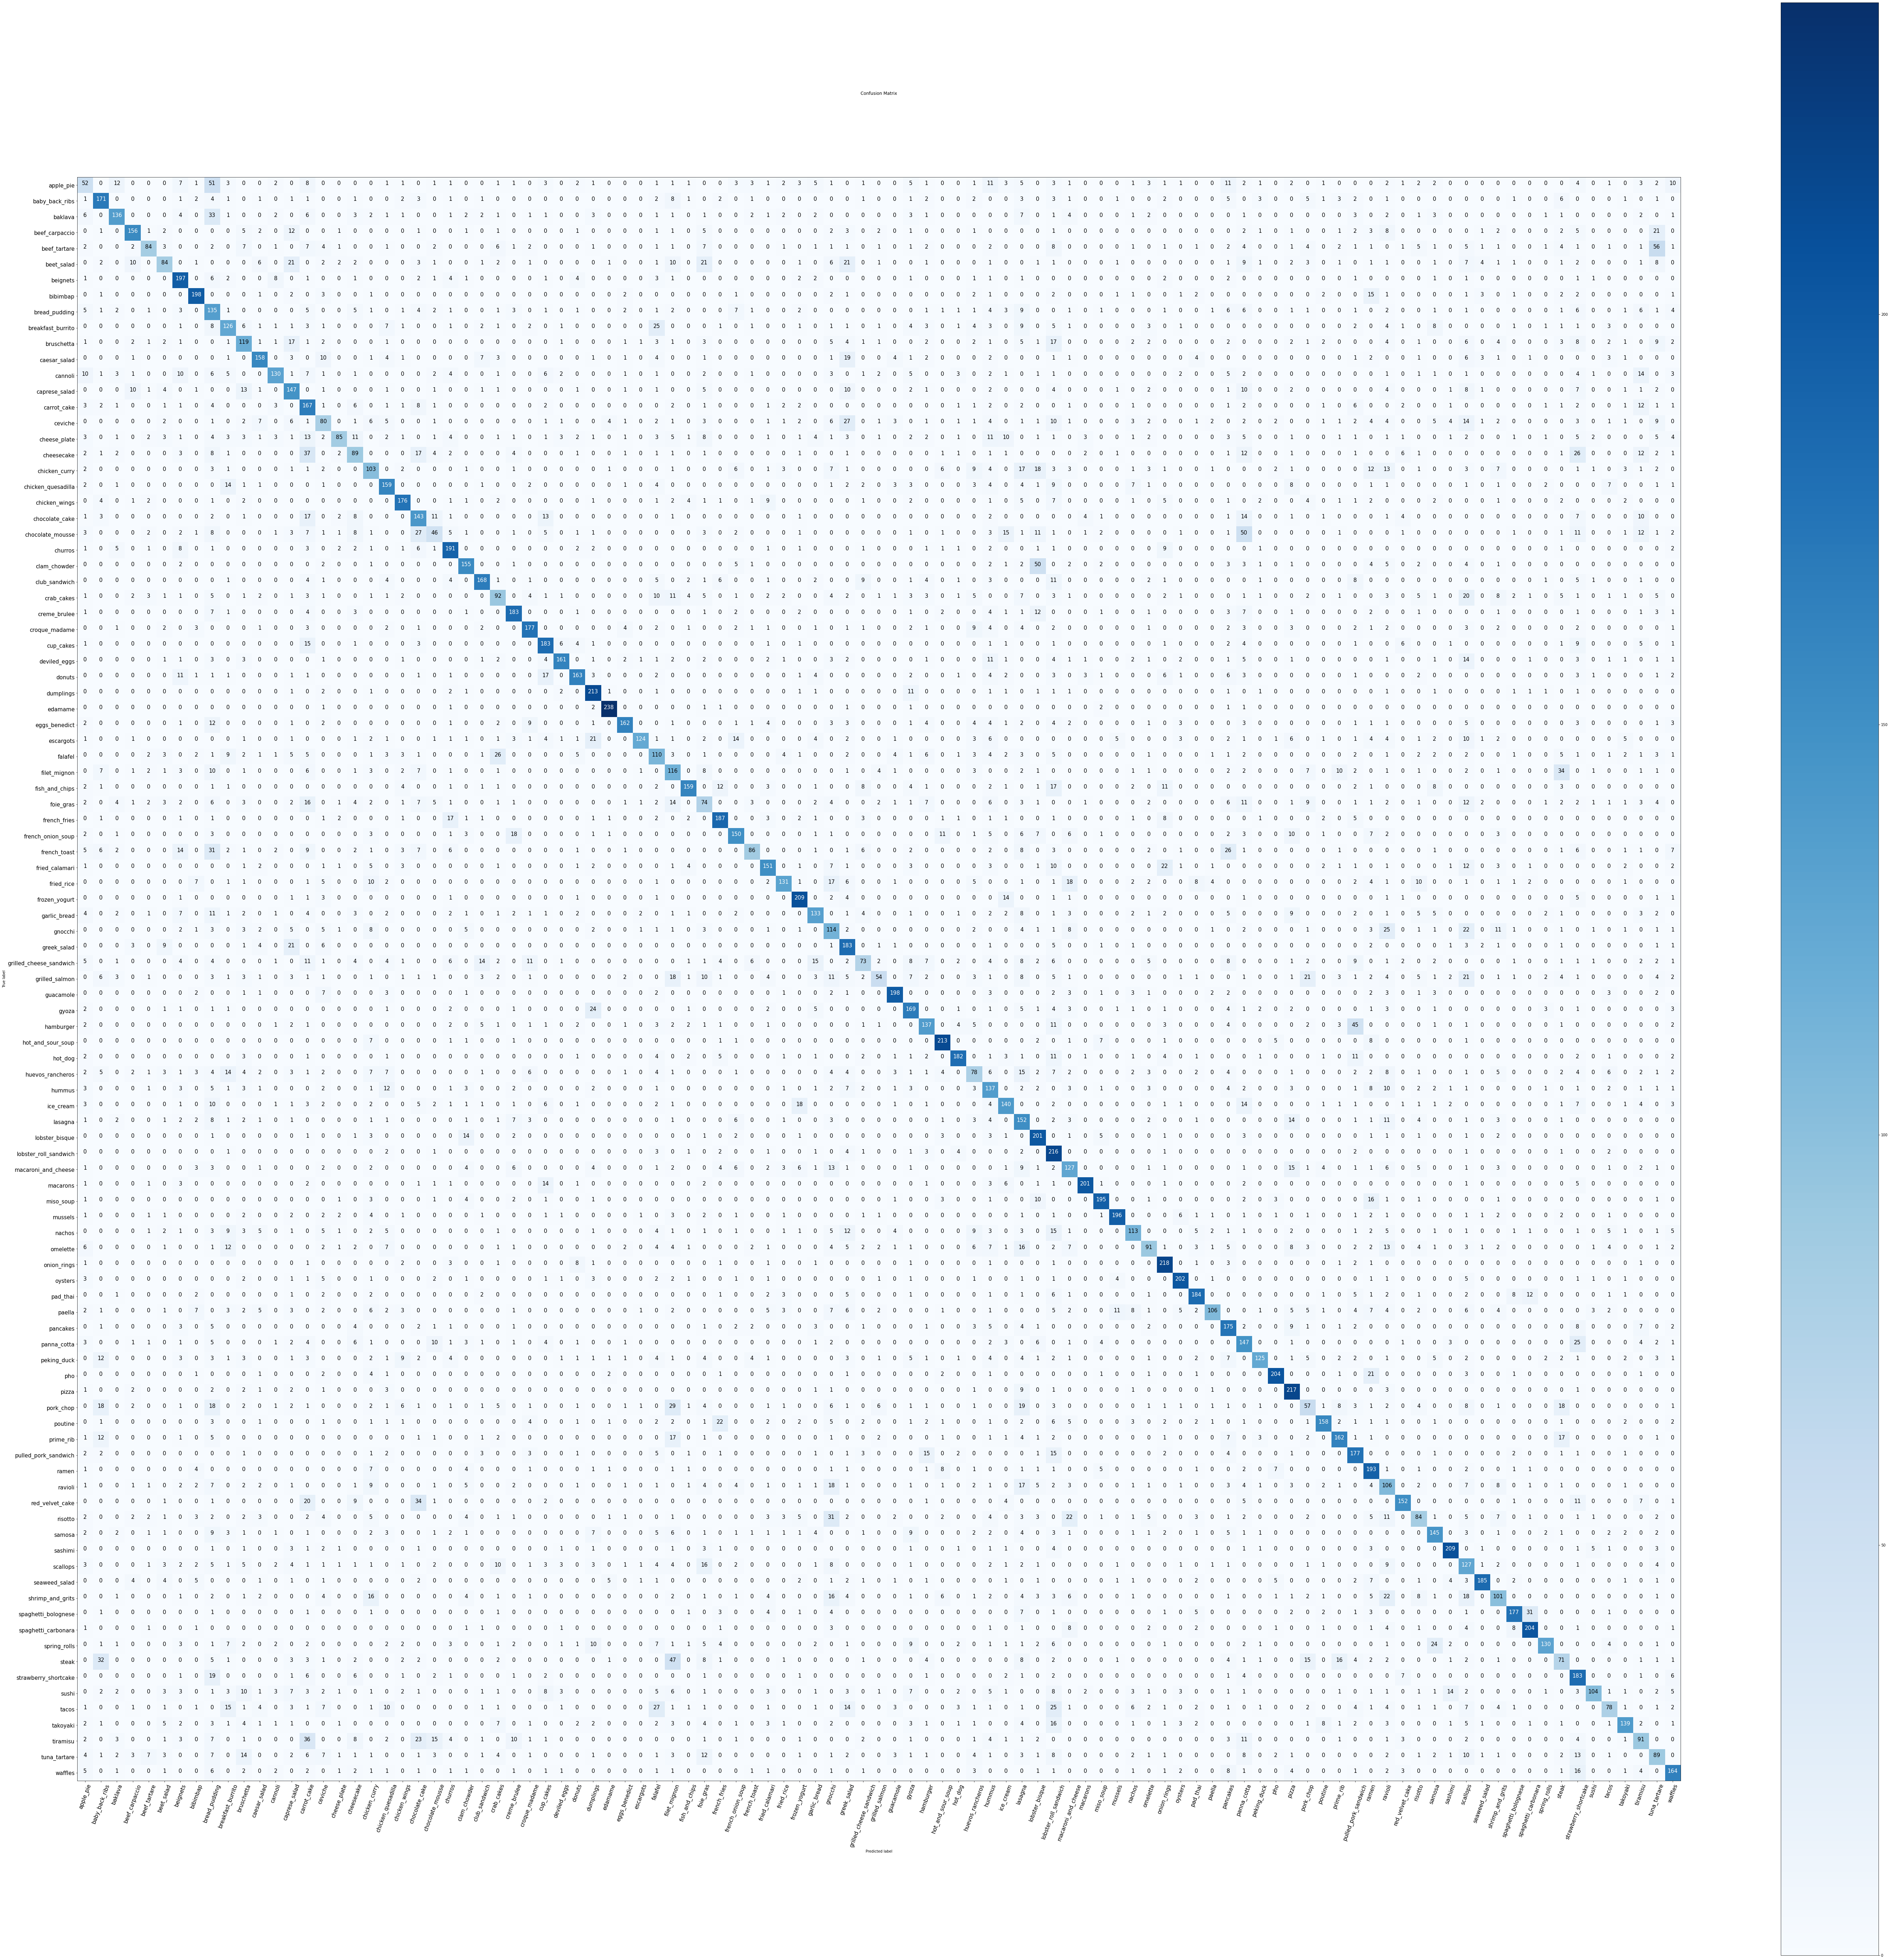

In [70]:
make_confusion_matrix(y_true=y_true, y_pred=y_preds,figsize=(100, 100), classes=class_names, savefig=True)

**Repport**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_true, y_pred=y_preds, target_names=class_names))

In [75]:
report_dict = classification_report(y_true=y_true, y_pred=y_preds, target_names=class_names, output_dict=True)

In [ ]:
report_dict

**Visualisation**

In [ ]:
f1_score_per_class = {}
for k,v in report_dict.items():
  if k == "accuracy":
    break
  else :
    f1_score_per_class[k] = v["f1-score"]

f1_score_per_class

In [96]:
# 
f1_scores = pd.DataFrame({"class_name": list(f1_score_per_class.keys()), "f1-score": list(f1_score_per_class.values())})

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

**Dataframe of the wrong predictions**

In [100]:
len(test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle=False))

25250

In [102]:
all_files = test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle=False)

In [110]:
# => file path label class_name predicted_label confidence predicted_class true/false prediction 
stats = pd.DataFrame({
    "file_path": [file_path.numpy() for file_path in all_files],
    "label": y_true,
    "class_name": [class_names[label] for label in y_true],
    "predicted_label": y_preds,
    "confidence": y_probs.max(axis=1),
    "predicted_class": [class_names[label] for label in y_preds],
})

In [111]:
stats.head()

,file_path,label,class_name,predicted_label,confidence,predicted_class
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,apple_pie,0,0.713776,apple_pie
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,apple_pie,0,0.575961,apple_pie
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,apple_pie,0,0.843065,apple_pie
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,apple_pie,38,0.347774,fish_and_chips
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,apple_pie,0,0.339222,apple_pie


In [112]:
# adding the true/false prediction column 
stats["true/false prediction"] = stats.label == stats.predicted_label

In [113]:
stats.head()

,file_path,label,class_name,predicted_label,confidence,predicted_class,true/false prediction
0,b'101_food_classes_10_percent/test/apple_pie/1...,0,apple_pie,0,0.713776,apple_pie,True
1,b'101_food_classes_10_percent/test/apple_pie/1...,0,apple_pie,0,0.575961,apple_pie,True
2,b'101_food_classes_10_percent/test/apple_pie/1...,0,apple_pie,0,0.843065,apple_pie,True
3,b'101_food_classes_10_percent/test/apple_pie/1...,0,apple_pie,38,0.347774,fish_and_chips,False
4,b'101_food_classes_10_percent/test/apple_pie/1...,0,apple_pie,0,0.339222,apple_pie,True


In [132]:
wrong_preds = stats[stats["true/false prediction"] == False]

In [126]:
# Grabbing only the false predictions 
wrong_preds.shape[0]

10559

In [ ]:
wrong_preds.head()

In [ ]:
wrong_preds.sort_values("confidence", ascending=False, inplace=True)
wrong_preds.reset_index(drop=True, inplace=True)

In [138]:
wrong_preds.head()

,file_path,label,class_name,predicted_label,confidence,predicted_class,true/false prediction
0,b'101_food_classes_10_percent/test/chocolate_m...,22,chocolate_mousse,60,0.999925,lobster_bisque,False
1,b'101_food_classes_10_percent/test/macarons/19...,63,macarons,29,0.999891,cup_cakes,False
2,b'101_food_classes_10_percent/test/ice_cream/3...,58,ice_cream,45,0.999864,frozen_yogurt,False
3,b'101_food_classes_10_percent/test/ice_cream/1...,58,ice_cream,45,0.999787,frozen_yogurt,False
4,b'101_food_classes_10_percent/test/churros/310...,23,churros,6,0.999643,beignets,False


In [140]:
# most confusing classes 
wrong_preds.value_counts(subset=["label","predicted_label"])

label  predicted_label
4      99                 56
0      8                  51
24     60                 50
22     73                 50
93     37                 47
                          ..
53     12                  1
52     94                  1
       85                  1
       81                  1
49     30                  1
Length: 3474, dtype: int64

**Visualize some wrong predictions**

In [194]:
for a in wrong_preds.itertuples():
  print(a)
  break

Pandas(Index=0, file_path=b'101_food_classes_10_percent/test/chocolate_mousse/2303080.jpg', label=22, class_name='chocolate_mousse', predicted_label=60, confidence=0.9999247789382935, predicted_class='lobster_bisque', _7=False)


**Make some predictions (Reading, resizing, rescaling)**

In [186]:
def preprocess_img(img_path, rescale=False):
  encoded_image_bytes = tf.io.read_file(img_path)
  img = tf.image.decode_image(encoded_image_bytes, channels=3)
  img = tf.image.resize(images=img, size=IMAGE_SIZE)
  if rescale:
    img = img/255.
  return img 

In [173]:
def predict_custom_img(img_path, class_names=None):
  preprocess_img(img_path)
  probs = model.predict(tf.expand_dims(img, axis=0))
  confidence, [label_predictd] = probs.max(), probs.argmax(axis=1)
  if class_names != None:
    class_name = class_names[label_predictd]
    return (confidence, label_predictd, class_name)
  else :
    return (confidence, label_predictd)

In [142]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip("custom_food_images.zip")

--2022-07-09 15:56:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.142.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  64.6MB/s    in 0.2s    

2022-07-09 15:56:02 (64.6 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [181]:
confidence, label , class_name  = predict_custom_img('/content/custom_food_images/pizza-dad.jpeg', class_names=class_names)